In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Data Import
The data is constituted of the history of clicks on ads of the month of Mars 2016. We assume that "Advertiser_ID" is the ID of the app being promoted on the clicked ad and "idfa" is the ID of the user that clicked

We deleted the lines with empty idfa

In [2]:
path = 'click_201603'
files = os.listdir(path)
parquet_files = [f for f in files if os.path.splitext(f)[1]=='.parquet']

In [3]:
clicks_df = pd.read_parquet(path+"\\"+parquet_files[0], engine='auto')
for f in parquet_files[1:]:
    clicks_df = pd.concat([clicks_df, pd.read_parquet(path+"\\"+f, engine='auto')])

In [4]:
clicks_df = clicks_df[clicks_df['idfa']!=''][['Advertiser_ID','idfa','DateEvent']]

In [5]:
sorted_clicks_df = clicks_df.sort_values(by='DateEvent').reset_index(drop=True)

In [6]:
sorted_clicks_df.head()

,Advertiser_ID,idfa,DateEvent
0,329,79382133-fef8-4e08-94a3-e72fce1ac395,2016-02-29 22:15:04
1,329,ccb8eecc-92df-4ab5-83da-98c9efd7005e,2016-02-29 22:15:06
2,161,64927121-8AC5-43E0-B362-3C747937B422,2016-02-29 22:15:07
3,329,ccb8eecc-92df-4ab5-83da-98c9efd7005e,2016-02-29 22:15:08
4,161,5DC62F12-0F34-430A-B0DC-212B050DBEB5,2016-02-29 22:15:08


In [7]:
sorted_clicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415843 entries, 0 to 1415842
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Advertiser_ID  1415843 non-null  object        
 1   idfa           1415843 non-null  object        
 2   DateEvent      1415843 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 32.4+ MB


In [8]:
sorted_clicks_df.describe()

,Advertiser_ID,idfa,DateEvent
count,1415843,1415843,1415843
unique,94,725433,902097
top,610,cd815fc7-b0c4-404f-94a2-e63044f87351,2016-03-24 07:03:47
freq,306176,542,15
first,NaN,NaN,2016-02-29 22:15:04
last,NaN,NaN,2016-03-31 21:57:47


The dataset contains approximetly 1.5 million clicks done by 725 433 users over 94 Apps 

In [8]:
sorted_clicks_df['Advertiser_ID'] = pd.to_numeric(sorted_clicks_df['Advertiser_ID'])

# Train Test split
For the testing set, we will be choosing users with over 5 clicks (avoid cold-start problem) and than pick the last click as the testing set.

The remaining data (ie users with less than 5 clicks and the past clicks apart from the last one for users with more than 5 clicks) will be added to the training set.   

In [9]:
def train_test_split(clicks_df, user_column, app_column):
    '''
    clicks_df is the dataframe containing all history of clicks, must contain user id and the clicked app id 
    user_column is the name of the column containing users id 
    app_column is the name of the column containing apps id
    
    return train and test sets as described above
    '''
    
    # keep only users with more than 5 clicks
    retreive = clicks_df[user_column].value_counts()[clicks_df[user_column].value_counts()>5].keys()
    df_test = clicks_df[clicks_df[user_column].isin(retreive)]
    
    # pick the last click as testing set
    df_test = df_test.groupby(user_column).tail(1)
    
    # all remaining is for the training set
    df_train = clicks_df.drop(index=df_test.index)
    
    if df_train.shape[0]+df_test.shape[0] == clicks_df.shape[0]:
        print('train - test split succeeded ! \n df_train shape:(%d,%d) \n df_test shape: (%d,%d) '
             % (df_train.shape[0], df_train.shape[1], df_test.shape[0], df_test.shape[1]))
        ratio = ((100*df_test.shape[0])/clicks_df.shape[0])
        print('testing set ratio = %.2f ' % (ratio))
        return df_train, df_test
    else:
        print('Oops, something went wrong ! \n df_train shape:(%d,%d) \n df_test shape: (%d,%d) '
             % (df_train.shape[0], df_train.shape[1], df_test.shape[0], df_test.shape[1]))
        print('original dataframe shape :(%d,%d)' % (clicks_df.shape[0], clicks_df.shape[1]))

In [10]:
df_train, df_test = train_test_split(sorted_clicks_df, 'idfa' , 'Advertiser_ID')

train - test split succeeded ! 
 df_train shape:(1382919,3) 
 df_test shape: (32924,3) 
testing set ratio = 2.33 


In [11]:
100*32924/750000

4.389866666666666

In [12]:
df_train_cv, df_val = train_test_split(df_train, 'idfa' , 'Advertiser_ID')

train - test split succeeded ! 
 df_train shape:(1360279,3) 
 df_test shape: (22640,3) 
testing set ratio = 1.64 


In [21]:
df_train_group_map.to_csv('clicks_train.csv', index=False)

In [30]:
df_test_group_map

,idfa,Advertiser_ID,click_times
0,222934,0,1
1,564439,5,1
2,83880,35,1
3,77951,0,1
4,371509,57,1
...,...,...,...
32919,230573,57,1
32920,92795,0,1
32921,342397,0,1
32922,291625,7,1


In [22]:
df_val_group_map.to_csv('clicks_validation.csv', index=False)

In [23]:
df_test_group_map.to_csv('clicks_test.csv', index=False)

In [13]:
print("The sparcity of the clicks matrix = %.2f percent" % (100*(1-sorted_clicks_df.shape[0]/(sorted_clicks_df['Advertiser_ID'].nunique()*sorted_clicks_df['idfa'].nunique()))))

The sparcity of the clicks matrix = 97.92 percent


In [14]:
sorted_clicks_df.head()

,Advertiser_ID,idfa,DateEvent
0,329,79382133-fef8-4e08-94a3-e72fce1ac395,2016-02-29 22:15:04
1,329,ccb8eecc-92df-4ab5-83da-98c9efd7005e,2016-02-29 22:15:06
2,161,64927121-8AC5-43E0-B362-3C747937B422,2016-02-29 22:15:07
3,329,ccb8eecc-92df-4ab5-83da-98c9efd7005e,2016-02-29 22:15:08
4,161,5DC62F12-0F34-430A-B0DC-212B050DBEB5,2016-02-29 22:15:08


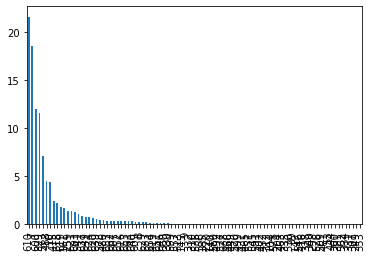

In [15]:
(sorted_clicks_df['Advertiser_ID'].value_counts()/sorted_clicks_df.shape[0]*100).plot(kind='bar')

In [16]:
apps_over_50k_clicks = sorted_clicks_df[sorted_clicks_df['Advertiser_ID'].isin(sorted_clicks_df['Advertiser_ID'].value_counts()[sorted_clicks_df['Advertiser_ID'].value_counts()>50000].keys())]

In [17]:
print("%d apps monopolize %.2f percent of the clicks of the dataset" % (apps_over_50k_clicks['Advertiser_ID'].nunique(),100*apps_over_50k_clicks.shape[0]/sorted_clicks_df.shape[0]))

7 apps monopolize 79.69 percent of the clicks of the dataset


This highlights the popularity of these 7 apps among users each app has over 50k clicks:

In [18]:
apps_over_50k_clicks['Advertiser_ID'].unique()

array([329,  10,   7, 573, 600, 610, 488], dtype=int64)

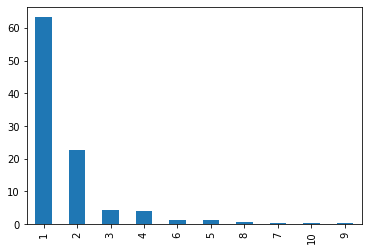

In [19]:
(sorted_clicks_df['idfa'].value_counts().value_counts()[:10]/sorted_clicks_df['idfa'].nunique()*100).plot(kind='bar')

In [20]:
print("%.2f percent of the users only click one time from the data" % (sorted_clicks_df['idfa'].value_counts().value_counts()[1]/sorted_clicks_df['idfa'].nunique()*100))
print("%.2f percent of the users click under 5 times from the data" % (sorted_clicks_df['idfa'].value_counts().value_counts().loc[[1,2,3,4,5]].sum()/sorted_clicks_df['idfa'].nunique()*100))

63.32 percent of the users only click one time from the data
95.46 percent of the users click under 5 times from the data


this proves that the cold-start problem is an important issue to be treated

# Metrics
Hit Ratio : 1 if the top-K list includes the truth, 0 otherwise. Then we calculate the average score on testing set

NDCG : is a hit ratio but considers the ranking too

In [21]:
def getHitRatio(ranklist, gtapp):
    '''
    ranklist : list of top-K recommanded apps
    gtapp : the app clicked y the user
    
    return 1 if the app clicked is in the recommanded list and 0 otherwise
    '''
    for app in ranklist:
        if app == gtapp:
            return 1
    return 0

In [22]:
def getNDCG(ranklist, gtapp):
    '''
    ranklist : list of top-K recommanded apps
    gtapp : the app clicked y the user
    
    return a value between 0 and 1, 1 if the app clicked is first in the recommanded list, the value decreases with the rank of 
    the app and returns 0 if the app is not in the list
    '''
    for i in range(len(ranklist)):
        app = ranklist[i]
        if app == gtapp:
            return math.log(2) / math.log(i+2)
    else:
        return 0

In [23]:
def getScores(model, test_set, K=5):
    '''
    model must have a 'top_K' method that returns top K recommandations for a certain user
    
    return the HR and NDCG scores over the test_set
    '''
    HR_score = 0
    NDCG_score = 0
    for i in range(test_set.shape[0]):
        rankList = model.top_K(test_set.iloc[i]['idfa'], K)
        HR_score += getHitRatio(rankList, test_set.iloc[i]['Advertiser_ID'])
        NDCG_score += getNDCG(rankList, test_set.iloc[i]['Advertiser_ID'])
    return (HR_score/test_set.shape[0]), (NDCG_score/test_set.shape[0])

# Abstract class for models 
this class will be used as a blueprint for every developed model

In [24]:
from abc import ABC, abstractmethod

In [25]:
class Model(ABC):
    def fit(self, train_set, val_set):
        pass
    def top_K(self, user, K):
        pass
    def set_params(self, params):
        pass
    def get_params(self):
        pass

# First model
this model is considered as a test for the metric functions

this models is a naive one that always returns the K most popular apps for every user

In [24]:
class popularity_model(Model):
    def __init__(self, pop_apps=[]):
        self.pop_apps = pop_apps
    
    def fit(self, train_set, val_set):
        '''
        This model does not include an optimization process 
        So the val_set is used in the training
        '''
        
        df = pd.concat([train_set,val_set])
        try:
            self.pop_apps = df['Advertiser_ID'].value_counts().index.to_list()
            print("The model is trained successfully ! ")
        except:
            print("Oops ! a problem happened during fitting !")
    
    def top_K(self, user, K=5):
        try :
            result = self.pop_apps[:K]
        except:
            print("Oops ! your model is not well trained or not enough items")
        
        return result
    
    def set_params(self, params={}):
        pass
    def get_params(self):
        print("this model has no params (memory based model)")

NameError: name 'Model' is not defined

In [25]:
first_model = popularity_model()

NameError: name 'popularity_model' is not defined

In [35]:
first_model.fit(df_train_group_map,df_val_group_map)

The model is trained successfully ! 


In [36]:
HR_score, NDCG_score = getScores(first_model, df_test_group_map, K=5)
print("Hit ratio on testing set = %.2f" % (100*HR_score),"%")
print("NDCG (Hit ratio with ranking consideration) on testing set = %.2f" % (100*NDCG_score),"%")

Hit ratio on testing set = 81.43 %
NDCG (Hit ratio with ranking consideration) on testing set = 50.92 %


# Matrix Factorization
* We are predicting how many times one user will click on an app, and we rank the times from high to low to make a top K list for recommendation

Matrix factorization is using two smaller matrices to represent a huge matrix (a pure linear transformation in order to save memory).

The main reason to use matrix factorization is not only to get as close as the original matrix, for if being that, that will be no room for doing the prediction. So rather than that, we look for the parameters by minimising a certain loss function 
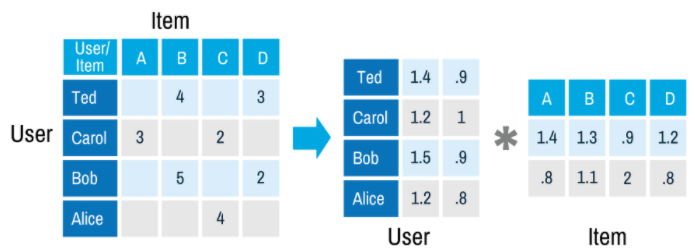

### Data preprocessing
build a user-map matrix that counts the number of clicks per user for every app. At the same time, make integer IDs for users

In [16]:
# click times per user 
df_train_cv['click_times'] = 1
df_val['click_times'] = 1
df_test['click_times'] = 1

In [17]:
df_train_group = df_train_cv.drop(columns='DateEvent').groupby(by = ['idfa','Advertiser_ID'], as_index=False).sum()
df_val_group = df_val.drop(columns='DateEvent').groupby(by = ['idfa','Advertiser_ID'], as_index=False).sum()
df_test_group = df_test.drop(columns='DateEvent').groupby(by = ['idfa','Advertiser_ID'], as_index=False).sum()

In [18]:
# To feed the keras model, we have to turn both the user_id and app_id into integer index
user_map = {i:v for i,v in enumerate(sorted_clicks_df.idfa.unique())}
inverse_user_map = {v:i for i,v in enumerate(sorted_clicks_df.idfa.unique())}

In [19]:
app_map = {i:v for i,v in enumerate(sorted_clicks_df.Advertiser_ID.unique())}
inverse_app_map = {v:i for i,v in enumerate(sorted_clicks_df.Advertiser_ID.unique())}

In [20]:
df_train_group_map = df_train_group.copy()
df_val_group_map = df_val_group.copy()
df_test_group_map = df_test_group.copy()

df_train_group_map['idfa'] = df_train_group['idfa'].map(inverse_user_map)
df_val_group_map['idfa'] = df_val_group['idfa'].map(inverse_user_map)
df_test_group_map['idfa'] = df_test_group['idfa'].map(inverse_user_map)

df_train_group_map['Advertiser_ID'] = df_train_group['Advertiser_ID'].map(inverse_app_map)
df_val_group_map['Advertiser_ID'] = df_val_group['Advertiser_ID'].map(inverse_app_map)
df_test_group_map['Advertiser_ID'] = df_test_group['Advertiser_ID'].map(inverse_app_map)

In [34]:
print('df_train_group_map shape : ', df_train_group_map.shape)
print('number of users : ', len(user_map.items()))
print('number of apps : ', len(app_map.items()))
print('The sparse matrix is one with shape (%d, %d), with %d non-zero click_times'
     %(len(user_map.items()),len(app_map.items()), df_train_group_map.shape[0]))
print('sparcity rate = %.2f' % (100*(1-((df_train_group_map.shape[0])/(len(user_map.items())*len(app_map.items()))))))

df_train_group_map shape :  (765091, 3)
number of users :  725433
number of apps :  94
The sparse matrix is one with shape (725433, 94), with 765091 non-zero click_times
sparcity rate = 98.88


#### We will be using stochastic gradient descent in order to minimize the loss function is the fastest training method

## Funk model
this model is based on the work made public by Funk in 2006 : https://sifter.org/simon/journal/20061211.html

we try to solve this regulated minimizing problem (equation taken from Sumit Sidana, 2009, Recommendation systems for online advertising) 
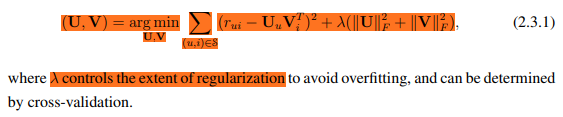

In [294]:
class FunkSGD(Model):
    def __init__(self, learning_rate=0.001, K_latent=10, regr_lambda=0.02, max_iter = 100, err_threshold = 0.000001):
        self.learning_rate = learning_rate
        self.K_latent = K_latent
        self.regr_lambda = regr_lambda
        self.max_iter = max_iter
        self.err_threshold = err_threshold
        
        self.params = {
            'n_users': 0,
            'n_apps': 0}
    
    def trainFunk(self, train_data):
        
        # We retreive the hyperparameters
        learning_rate = self.learning_rate
        K_latent = self.K_latent
        regr_lambda = self.regr_lambda
        
        n_users = self.params['n_users']
        n_apps = self.params['n_apps']
        

        # We initiate with a uniform distribution
        U = np.random.uniform(0,1/np.sqrt(K_latent), size=(n_users,K_latent))
        V = np.random.uniform(0,1/np.sqrt(K_latent), size=(K_latent,n_apps)) 

        # We will create a small training data set of size K
        temp = train_data

        # We create our X and Y from the above temp dataset
        y = np.array(temp['click_times'])
        x = np.array(temp.drop('click_times',axis=1))
        current_it = 1
        error = self.err_threshold
        while (current_it <= self.max_iter) and (abs(error) >= self.err_threshold):
            print('epoch ',current_it)
            for i in range(temp.shape[0]): # Calculating gradients for point in our K sized dataset
                user = x[i,0]
                app = x[i,1]
                prediction = np.dot(U[user,:],V[:,app])
                error = y[i]-prediction

                #Updating the weights of U and V with the above calculated Gradients
                V[:,app] += learning_rate*(error*U[user,:]-regr_lambda*U[app,:])
                U[user,:] += learning_rate*(error*V[:,app]-regr_lambda*U[user,:])
            current_it += 1

        self.params['U'] = U
        self.params['V'] = V
        self.params['R'] = np.dot(U,V)
    
    def fit(self, train_set, val_set):
        
        self.params['n_users'] = len(train_set['idfa'].unique())
        self.params['n_apps'] = len(train_set['Advertiser_ID'].unique())
        
        self.trainFunk(train_set)
        HR_score, NDCG_score = getScores(self, val_set)
            
        print("Funk Model trained successfully")
        print("Hit ratio on validation set = %.2f" % (100*HR_score),"%")
        print("NDCG (Hit ratio with ranking consideration) on validation set = %.2f" % (100*NDCG_score),"%")
        
    def top_K(self, user, K=5):
        try :
            result = self.params['R'][user,].argsort()[-K:].tolist()
            result.reverse()
        except:
            print("Oops ! your model is not well trained or not enough items")
        
        return result
    def set_params(self, params={}):
        pass
    def get_params(self):
        return self.params['R']

In [295]:
funk_model = FunkSGD()

In [296]:
funk_model.fit(df_train_group_map,df_val_group_map)

epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89
epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch  99
epoch  100
Funk Mod

In [299]:
HR_score, NDCG_score = getScores(funk_model, df_test_group_map, K=5)
print("Hit ratio on testing set = %.2f" % (100*HR_score),"%")
print("NDCG (Hit ratio with ranking consideration) on testing set = %.2f" % (100*NDCG_score),"%")

Hit ratio on testing set = 85.17 %
NDCG (Hit ratio with ranking consideration) on testing set = 69.40 %


In [397]:
# difference from popularity model 
sample_100 = df_train_group_map.sample(100)
s = 0
for i in range(100):
    if (set(funk_model.top_K(sample_100['idfa'].iloc[i])) == set(first_model.top_K(sample_100['idfa'].iloc[i]))):
        s+=1
print("Similarity level is up to %.2f" % (s),"%")

Similarity level is up to 0.00 %


## Koren model
this model is based on the paper : Yehuda Koren, 2008, Factorization meets the neighborhood: a multifaceted collaborative filtering model

By adding new variables ( Yj ), this model is proven to be more performing on implicit feedback which is our case with clicks dataset.  In addition it adds to the traditional model bias terms that helps avoid the popularity bias. 

We will be try to solve this minimization problem : (equation taken from Sumit Sidana, 2009, Recommendation systems for online advertising) 
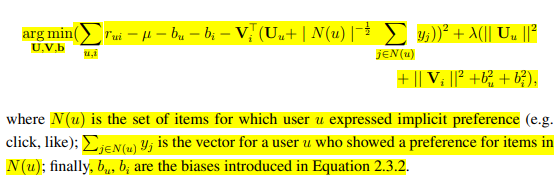

In [390]:
class KorenSGD(Model):
    def __init__(self, learning_rate=0.001, K_latent=10, regr_lambda=0.015, regr_lambda1 = 0.005):
        self.learning_rate = learning_rate
        self.K_latent = K_latent
        self.regr_lambda = regr_lambda
        self.regr_lambda1 = regr_lambda1
        self.params = {
            'n_users': 0,
            'n_apps': 0}
        
    def trainKoren(self, train_data):
        # We retreive the hyperparameters
        learning_rate = self.learning_rate
        K_latent = self.K_latent
        regr_lambda = self.regr_lambda
        regr_lambda1 = self.regr_lambda1

        n_users = len(train_data['idfa'].unique())
        n_apps = len(train_data['Advertiser_ID'].unique())

        nu = train_data['click_times'].mean()

        # We initiate with a uniform distribution
        R = np.zeros(shape=(n_users,n_apps))
        U = np.random.uniform(0,1/np.sqrt(K_latent), size=(n_users,K_latent))
        V = np.random.uniform(0,1/np.sqrt(K_latent), size=(K_latent,n_apps))
        Y = np.random.uniform(0,1/np.sqrt(K_latent), size=(n_apps,K_latent))
        bu = np.random.uniform(0,1/np.sqrt(K_latent), size=n_users)
        ba = np.random.uniform(0,1/np.sqrt(K_latent), size=n_apps)
        
        
        temp = train_data

        # We create our X and Y from the above temp dataset
        y = np.array(temp['click_times'])
        x = np.array(temp.drop('click_times',axis=1))

        for i in range(temp.shape[0]): # We loop over the data
            user = x[i,0]
            app = x[i,1]
            
            # set of clicked apps
            N = np.array(df_train_group_map[df_train_group_map['idfa']== user]['Advertiser_ID'])
            
            # Prediction with Koren's formula
            prediction = nu+bu[user]+ba[app]+np.dot(U[user,:]+(1/np.sqrt(len(N)))*np.sum(Y[N,:], axis=0),V[:,app])
            
            R[user,app] = prediction #updating the target matrix
            
            error = y[i]-prediction

            #Updating the weights of U and V, the Bias and other variables with the above calculated Gradients
            bu[user]+=learning_rate*(error-regr_lambda1*bu[user])
            ba[app]+=learning_rate*(error-regr_lambda1*ba[app])

            V[:,app]+=learning_rate*(error*(U[user,:]+(1/np.sqrt(len(N)))*np.sum(Y[N,:], axis=0))-regr_lambda*V[:,app])
            U[user,:]+=learning_rate*(error*V[:,app]-regr_lambda*U[user,:])

            Y[N,:] = Y[N,:]+learning_rate*(error*(1/np.sqrt(len(N)))*V[:,app]-regr_lambda*Y[N,:])
        
        # save trained params
        self.params['U'] = U
        self.params['V'] = V
        self.params['R'] = R
        
    def fit(self, train_set, val_set):
        
        self.params['n_users'] = len(train_set['idfa'].unique())
        self.params['n_apps'] = len(train_set['Advertiser_ID'].unique())
        
        self.trainKoren(train_set)
        HR_score, NDCG_score = getScores(self, val_set)
        
        print("Koren Model trained successfully")
        print("Hit ratio on validation set = %.2f" % (100*HR_score),"%")
        print("NDCG (Hit ratio with ranking consideration) on validation set = %.2f" % (100*NDCG_score),"%")
    
    def top_K(self, user, K=5):
        try :
            result = self.params['R'][user,].argsort()[-K:].tolist()
            result.reverse()
        except:
            print("Oops ! your model is not well trained or not enough items")
        
        return result

In [227]:
koren = KorenSGD()

In [228]:
koren.fit(df_train_group_map,df_val_group_map)

Koren Model trained successfully
Hit ratio on validation set = 95.75 %
NDCG (Hit ratio with ranking consideration) on validation set = 91.91 %


In [229]:
HR_score, NDCG_score = getScores(koren, df_test_group_map, K=5)
print("Hit ratio on testing set = %.2f" % (100*HR_score),"%")
print("NDCG (Hit ratio with ranking consideration) on testing set = %.2f" % (100*NDCG_score),"%")

Hit ratio on testing set = 94.38 %
NDCG (Hit ratio with ranking consideration) on testing set = 91.14 %


In [230]:
# difference from popularity model 
sample_100 = df_train_group_map.sample(100)
s = 0
for i in range(100):
    if (set(koren.top_K(sample_100['idfa'].iloc[i])) == set(first_model.top_K(sample_100['idfa'].iloc[i]))):
        s+=1
print("Similarity level is up to %.2f" % (s),"%")

Similarity level is up to 0.00 %


## Hu Model
This model is based on the paper : Yifan Hu, Yehuda Koren, and Chris Volinsky, 2008c, Collaborative filtering for implicit feedback datasets

This model tries to solve this minimization problem by ALS (alternating least squares) method: 
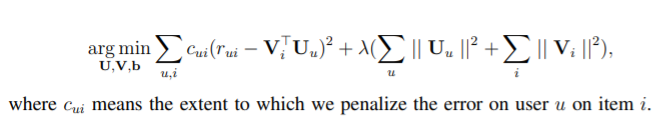

In [391]:
class HuALS(Model):
    def __init__(self, alpha = 40, K_latent = 10, regr_lambda = 0.01, max_iter = 10):
        self.alpha = alpha # user-app preference parameter
        self.K_latent = K_latent
        self.regr_lambda = regr_lambda
        self.max_iter = max_iter
        self.params = {
            'n_users': 0,
            'n_apps': 0}
        
    def trainHu(self, train_data):
        # We retreive the hyperparameters
        alpha = self.alpha
        K_latent = self.K_latent
        regr_lambda = self.regr_lambda
        max_iter = self.max_iter

        n_users = len(train_data['idfa'].unique())
        n_apps = len(train_data['Advertiser_ID'].unique())

        # We build the penalization and preference matrices
        C = 1 + alpha*np.array(train_data.pivot_table(values='click_times', index=['idfa'], columns ='Advertiser_ID').fillna(0).values, dtype="int")
        P = np.array(train_data.groupby(['idfa','Advertiser_ID']).size().reset_index(name='count').pivot_table(values='count', index=['idfa'], columns ='Advertiser_ID').fillna(0).values, dtype="int")
        
        # We initiate with a uniform distribution
        U = np.random.uniform(0,1/np.sqrt(K_latent), size=(n_users,K_latent))
        V = np.random.uniform(0,1/np.sqrt(K_latent), size=(K_latent,n_apps))

        # We use ALS to find the minimum
        for sweep in range(max_iter):
            # recomputing all user factors
            A = np.dot(V,V.T)

            for user in range(n_users):
                pu = P[user,:]

                inv = np.linalg.inv(A+np.dot(V,((C[user,:]-1)*V).T)+regr_lambda*np.identity(K_latent))
                U[user,:] = np.dot(inv,np.dot(V,(C[user,:]*pu.T).T))

            # recomputing all app factors
            B = np.dot(U.T,U)

            for app in range(n_apps):
                pa = P[:,app]

                inv = np.linalg.inv(B+np.dot(U.T,((C[:,app]-1)*U.T).T)+regr_lambda*np.identity(K_latent))
                V[:,app] = np.dot(inv,np.dot(U.T,(C[:,app]*pa.T).T))
        
        # save trained params
        self.params['U'] = U
        self.params['V'] = V
        self.params['R'] = np.dot(U,V)
        
    def fit(self, train_set, val_set):
        
        self.params['n_users'] = len(train_set['idfa'].unique())
        self.params['n_apps'] = len(train_set['Advertiser_ID'].unique())
        
        self.trainHu(train_set)
        HR_score, NDCG_score = getScores(self, val_set)
        
        print("Koren Model trained successfully")
        print("Hit ratio on validation set = %.2f" % (100*HR_score),"%")
        print("NDCG (Hit ratio with ranking consideration) on validation set = %.2f" % (100*NDCG_score),"%")
    
    def top_K(self, user, K=5):
        try :
            result = self.params['R'][user,].argsort()[-K:].tolist()
            result.reverse()
        except:
            print("Oops ! your model is not well trained or not enough items")
        
        return result

In [392]:
hu_model = HuALS()

In [393]:
hu_model.fit(df_train_group_map,df_val_group_map)

Koren Model trained successfully
Hit ratio on validation set = 96.04 %
NDCG (Hit ratio with ranking consideration) on validation set = 91.29 %


In [394]:
HR_score, NDCG_score = getScores(hu_model, df_test_group_map, K=5)
print("Hit ratio on testing set = %.2f" % (100*HR_score),"%")
print("NDCG (Hit ratio with ranking consideration) on testing set = %.2f" % (100*NDCG_score),"%")

Hit ratio on testing set = 94.98 %
NDCG (Hit ratio with ranking consideration) on testing set = 90.52 %


In [395]:
# difference from popularity model 
sample_100 = df_train_group_map.sample(100)
s = 0
for i in range(100):
    if (set(hu_model.top_K(sample_100['idfa'].iloc[i])) == set(first_model.top_K(sample_100['idfa'].iloc[i]))):
        s+=1
print("Similarity level is up to %.2f" % (s),"%")

Similarity level is up to 0.00 %


# Factorization Machines